In [2]:
import torch
import numpy as np
import os
import requests
import torch.nn as nn
print(torch.cuda.is_available())

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

True


In [3]:
# import zipfile
# from io import BytesIO

# # Replace 'YOUR_ZIP_URL' with the actual URL of your zip file
# zip_url = 'https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=drive_link&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ'

# # Download the zip file
# response = requests.get(zip_url)

# # Extract the zip file
# with zipfile.ZipFile(BytesIO(response.content)) as z:
#     z.extractall()

# import os

# # List files in the current directory
# os.listdir()

In [4]:
import zipfile

# Define the destination folder for extracted files
extraction_folder = "D:/Data science/NLP PROJECT/Copy of img_align_celeba"

# zip_file_path = '/content/drive/MyDrive/Colab Notebooks/Image for gan/Copy of img_align_celeba.zip'
# # Create the folder if it doesn't exist
# os.makedirs(extraction_folder, exist_ok=True)

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extraction_folder)


# # List the contents of the folder
# os.listdir(extraction_folder)

In [5]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define parameters for data augmentation and preprocessing
image_size = (64, 64)  # Adjust as needed
# batch_size = 32

# Define data transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Adjust normalization values
])

dataset = ImageFolder(root=extraction_folder, transform=transform)
stats = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


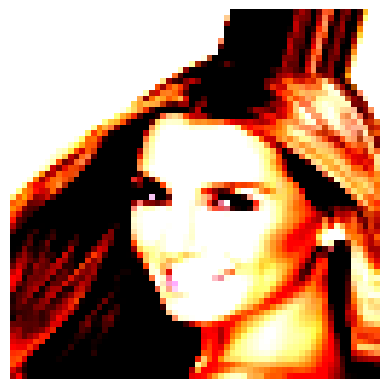

In [6]:
import matplotlib.pyplot as plt
img = dataset[0][0].permute(1, 2, 0).numpy()
plt.imshow(img)
# plt.title(f'Class: {class_names[label]}')
plt.axis('off')
plt.show()

In [7]:
# Lets break our data in train and test data
from sklearn.model_selection import train_test_split


# X_train , X_test = train_test_split(dataset,test_size= 0.25)

from torch.utils.data import DataLoader
NUM_BATCHES = 64
train_Dataloader = DataLoader(dataset, batch_size=NUM_BATCHES, shuffle=True)
# test_Dataloader = DataLoader(X_test,batch_size = NUM_BATCHES,shuffle = True)

In [8]:
train_data_batch = next(iter(train_Dataloader))
# train_data_batch[1].replace(1)
train_data_batch[1][train_data_batch[1] == 0] = 1
real_data = train_data_batch[0].to(device)
real_data.shape

torch.Size([64, 3, 64, 64])

LETS BUILD DESCRIMINATOR


In [9]:
class Discriminator_model_v1(nn.Module):
    def __init__(self, channels_num, output_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_num, output_features, kernel_size=4, stride=2, padding=1, bias=False),  # 32x32
            nn.LeakyReLU(0.2, inplace=True),
            self.block_(output_features, output_features*2),  # 16x16
            self.block_(output_features*2, output_features*4),  # 8x8
            self.block_(output_features*4, output_features*8),  # 4x4
            self.block_(output_features*8, output_features*16),
            nn.Conv2d(
                output_features*16, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid()
        )

    def block_(self, input_feature, output_feature):
        return nn.Sequential(
            nn.Conv2d(
                input_feature, output_feature, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_feature),
            # nn.Dropout2d(p=0.5),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, X: torch.tensor):
        return self.disc(X)

In [10]:
CHANNEL_NUM = 3
FEATURE_DISC = 64

discriminator_v1 = Discriminator_model_v1(CHANNEL_NUM, FEATURE_DISC).to(device)
discriminator_v1

Discriminator_model_v1(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Sequential(


In [11]:
# Let's build Generator
# first generate noise
size_noise = 100
random_state = 42
torch.cuda.manual_seed(random_state)
noise = torch.randn(8, size_noise, 1, 1, device=device)
print(noise.shape, type(noise))
# noise = noise.reshape(100,1,1)

torch.Size([8, 100, 1, 1]) <class 'torch.Tensor'>


In [12]:
class Genrator_v1(nn.Module):
    def __init__(self, input_length, feature_channel, output_channel):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(input_length, feature_channel*16,
                               kernel_size=2, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_channel*16),
            nn.ReLU(True),  # 2x2
            self._block(feature_channel*16, feature_channel*8),  # 4x4
            self._block(feature_channel*8, feature_channel*4),  # 8x8
            self._block(feature_channel*4, feature_channel*2),  # 16x16
            self._block(feature_channel*2, feature_channel),
            # self._block(feature_channel , feature_channel),
            # self._block(feature_channel , feature_channel),
            # self._block(feature_channel , feature_channel),

            nn.ConvTranspose2d(feature_channel, output_channel,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.Tanh()
        )

    def _block(self, input_channel, output_channel):
        return nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(True)
        )

    def forward(self, X: torch.tensor):
        return self.gen(X)

In [13]:
from torchvision.utils import make_grid
genrator_v1 = Genrator_v1(100, 8, 3).to(device)
genrator_v1


def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]


def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(
        make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


genrator_v1

Genrator_v1(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (5): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (6): Sequential(
      

In [14]:
v = discriminator_v1(real_data)
v = v.squeeze()
torch.cuda.empty_cache()
v

tensor([0.5209, 0.5245, 0.4876, 0.5149, 0.5475, 0.5126, 0.4902, 0.4813, 0.4641,
        0.5101, 0.5700, 0.4762, 0.5102, 0.5312, 0.5115, 0.4717, 0.5011, 0.4932,
        0.5123, 0.4652, 0.5021, 0.5789, 0.4402, 0.5921, 0.5650, 0.5657, 0.5560,
        0.4370, 0.4823, 0.5254, 0.4717, 0.4842, 0.5063, 0.4819, 0.4424, 0.5455,
        0.4721, 0.6120, 0.4582, 0.4885, 0.4978, 0.4605, 0.4787, 0.5111, 0.4919,
        0.4926, 0.5349, 0.5126, 0.5375, 0.5352, 0.5771, 0.5178, 0.4397, 0.4498,
        0.4826, 0.6293, 0.5143, 0.4877, 0.5915, 0.5014, 0.5449, 0.5702, 0.4891,
        0.5957], device='cuda:0', grad_fn=<SqueezeBackward0>)

torch.Size([8, 3, 64, 64])


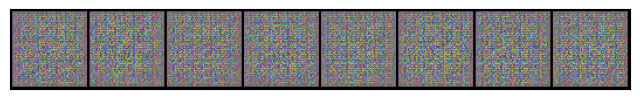

In [15]:
Loss_function = nn.BCEWithLogitsLoss()
#  Lets see fake generated images
img_fakes = genrator_v1(noise).cpu()
print(img_fakes.shape)
show_images(img_fakes)

In [16]:
# Lets train Generator and Discriminator
def train_discriminator(gen_model, disc_model, real_images, opm: torch.optim):
    opm.zero_grad()

    real_preds = disc_model(real_images).squeeze()
    real_class = torch.ones(real_preds.shape[0], device=device)
    real_class = torch.where(real_class == 1, 0.9, real_class)

    loss_fn = nn.BCELoss()
    loss_d = loss_fn(real_preds, real_class)
    score_real = torch.mean(real_preds)
    size_noise = 100
    random_state = 42
    torch.cuda.manual_seed(random_state)
    noise = torch.randn(8, size_noise, 1, 1, device=device)

    fake_images = gen_model(noise)
    fake_preds = disc_model(fake_images).squeeze()
    fake_class = torch.zeros(fake_preds.shape[0], device=device)
    fake_class = torch.where(fake_class == 0, 0.1, fake_class)

    loss_g = loss_fn(fake_preds, fake_class)
    score_fake = torch.mean(fake_preds)
    loss = loss_g + loss_d

    loss.backward()
    opm.step()
    return loss, loss_d, loss_g, score_fake, score_real

In [17]:
def train_generator(gen_model, disc_model, opm: torch.optim):

    loss_fn = nn.BCELoss()

    size_noise = 100
    random_state = 42
    torch.cuda.manual_seed(random_state)
    noise = torch.randn(8, size_noise, 1, 1, device=device)

    fake_images = gen_model(noise)
    fake_preds = disc_model(fake_images).squeeze()
    fake_class = torch.ones(fake_images.shape[0], device=device)
    fake_class = torch.where(fake_class == 1, 0.9, fake_class)

    loss_g = loss_fn(fake_preds, fake_class)
    score_fake = torch.mean(fake_preds)

    opm.zero_grad()
    loss_g.backward()
    opm.step()
    return loss_g, score_fake

In [18]:
torch.cuda.empty_cache()

In [19]:
# lets train out models
from tqdm.auto import tqdm

epoch = 10

for epoch in tqdm(range(epoch)):
    optimizer_discriminator = torch.optim.Adam(
        discriminator_v1.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_generator = torch.optim.Adam(
        genrator_v1.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for batch_idx, (real_images, _) in enumerate(train_Dataloader):

        loss, loss_d, loss_g, score_fake, score_real = train_discriminator(
            genrator_v1, discriminator_v1, real_images.to(device), optimizer_discriminator)

        loss_generator, score_generator = train_generator(
            genrator_v1, discriminator_v1, optimizer_generator)

        if batch_idx % 100 == 0:

            print(
                f'Runnig epoch number {epoch} ---------------------------------------------')
            print(
                f'Discriminator : Loss : {loss}, Discriminator score : {score_real};\n Generator Loss : {loss_generator}, Generator Score : {score_generator}')

  0%|          | 0/10 [00:00<?, ?it/s]

Runnig epoch number 0 ---------------------------------------------
Discriminator : Loss : 1.3499014377593994, Discriminator score : 0.5080692768096924;
 Generator Loss : 4.2626190185546875, Generator Score : 0.009597226977348328
Runnig epoch number 0 ---------------------------------------------
Discriminator : Loss : 0.6576977968215942, Discriminator score : 0.870125412940979;
 Generator Loss : 2.1708145141601562, Generator Score : 0.09154298901557922
Runnig epoch number 0 ---------------------------------------------
Discriminator : Loss : 0.6565214395523071, Discriminator score : 0.8822120428085327;
 Generator Loss : 2.1093993186950684, Generator Score : 0.09949301928281784
Runnig epoch number 0 ---------------------------------------------
Discriminator : Loss : 1.0712525844573975, Discriminator score : 0.7111186981201172;
 Generator Loss : 1.08201265335083, Generator Score : 0.3685489296913147
Runnig epoch number 0 ---------------------------------------------
Discriminator : Los

torch.Size([8, 3, 64, 64])


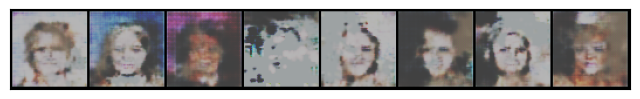

In [24]:
img_fakes = genrator_v1(noise).cpu()
print(img_fakes.shape)
show_images(img_fakes)

In [23]:
print(score_generator)

tensor(0.1001, device='cuda:0', grad_fn=<MeanBackward0>)
